## 1. Descriptive Analysis of the Data

In this section, we explore the training dataset to understand its structure, variables, and missing values.


In [459]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("application_train.csv")
df.shape, df.columns[:10]

((307511, 122),
 Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
        'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
        'AMT_CREDIT', 'AMT_ANNUITY'],
       dtype='object'))

### 1.1 Dataset Overview

In [461]:
df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.2 Missing Values

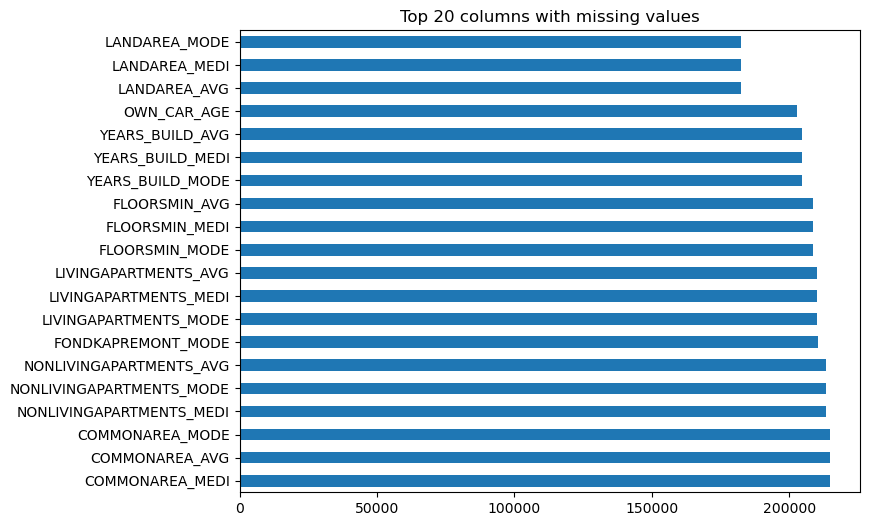

In [463]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
missing_values.head(20)

#Visualisation 

missing_values.head(20).plot(kind='barh', figsize=(8,6))
plt.title("Top 20 columns with missing values")
plt.show()

### 1.3 Target Variable (`TARGET`)

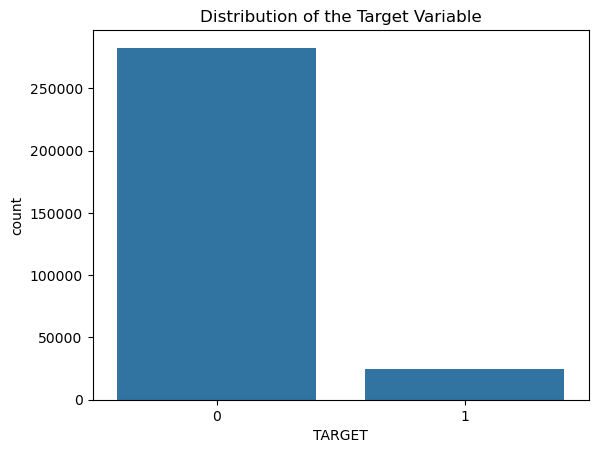

In [465]:
df['TARGET'].value_counts(normalize=True)
sns.countplot(x='TARGET', data=df)
plt.title("Distribution of the Target Variable")
plt.show()

### 1.4 Key Features Exploration

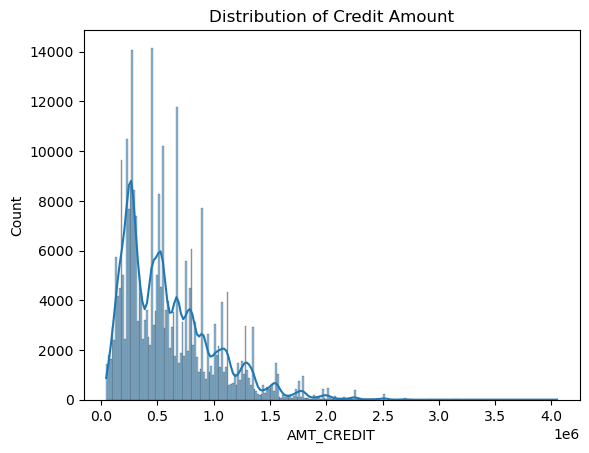

In [471]:
df[['AMT_CREDIT', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED']].describe()

#Visualisation 

sns.histplot(df['AMT_CREDIT'], kde=True)
plt.title("Distribution of Credit Amount")
plt.show()

#sns.histplot(df['AMT_INCOME_TOTAL'], kde=True)
#plt.title("Distribution of Income")
#plt.show()

### 1.5 Correlation between numerical variables

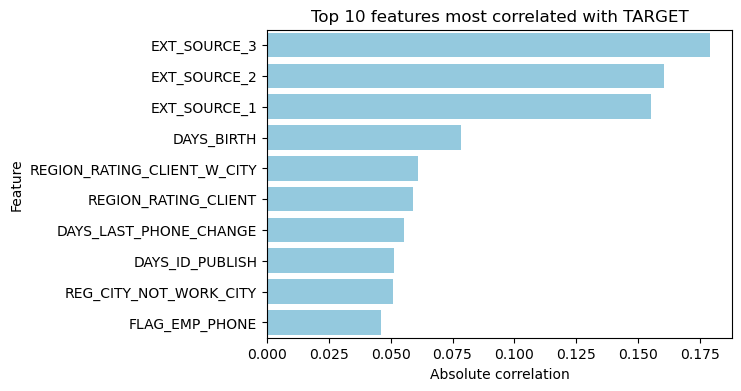

In [473]:
# top 10 features les plus corrélées
corr = df.corr(numeric_only=True)['TARGET'].abs().sort_values(ascending=False)[1:11]

plt.figure(figsize=(6, 4))
sns.barplot(x=corr.values, y=corr.index, color='skyblue')  # utiliser color= au lieu de palette=
plt.title("Top 10 features most correlated with TARGET")
plt.xlabel("Absolute correlation")
plt.ylabel("Feature")
plt.show()

### Conclusion of Step 1 — Descriptive Analysis

The exploration of the `application_train.csv` dataset reveals several key insights:

- The target variable `TARGET` is **highly imbalanced**, with around **91% of non-default clients** (`TARGET = 0`) and **0.9 of defaulting clients** (`TARGET = 1`).  
  This confirms that we are dealing with a **binary classification problem with class imbalance**.  
  In future stages, this task will be extended to a **multiclass problem** to better capture varying levels of credit risk.

- A **large number of missing values** are observed across several columns, especially in credit bureau and external source features.  
  Proper handling of missing data will be necessary during preprocessing.

- The **distribution of credit amounts (`AMT_CREDIT`)** is right-skewed: most clients request relatively small loans (peak around 80,000), and fewer clients request very high amounts.

- The **distribution of income (`AMT_INCOME_TOTAL`)** is extremely uneven, with most clients concentrated at low income levels.
The histogram appears almost flat near zero on the count axis, suggesting the presence of large outliers or potential scaling issues.

- The **correlation with the target** shows that the most informative variables are mainly:

    - EXT_SOURCE_3, EXT_SOURCE_2, EXT_SOURCE_1 (external credit scores)

    - DAYS_BIRTH (client age)
These variables will likely be important for modeling.

Overall, this descriptive analysis provides a first understanding of the dataset’s structure and challenges: **imbalanced target, missing values, skewed distributions, and complex feature interactions**.


## 2. Implementation of the Necessary Pre-processing

In this step, we prepare the dataset for modeling by handling missing values, encoding categorical features, scaling numerical features, and splitting the data into training and testing sets.


### 2.1 Handling Missing Values

We check which features have missing values and decide on appropriate strategies: 
- Drop columns with too many missing values.
- Impute missing numerical values with median.
- Impute missing categorical values with mode.


In [477]:
# Identifier les colonnes avec NaN
missing_values = df.isnull().sum()
missing_cols = missing_values[missing_values > 0].index.tolist()

# Colonnes avec trop de NaN à supprimer (par exemple >30% des lignes)
threshold = 0.3 * len(df)
cols_to_drop = [col for col in missing_cols if missing_values[col] > threshold]
df = df.drop(columns=cols_to_drop)

# Imputer les colonnes numériques restantes par la médiane
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in num_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())  # assignation directe

# Imputer les colonnes catégorielles par la valeur la plus fréquente
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])  # assignation directe
#Visualition 
df.isnull().sum().head(20)

SK_ID_CURR                    0
TARGET                        0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
CNT_CHILDREN                  0
AMT_INCOME_TOTAL              0
AMT_CREDIT                    0
AMT_ANNUITY                   0
AMT_GOODS_PRICE               0
NAME_TYPE_SUITE               0
NAME_INCOME_TYPE              0
NAME_EDUCATION_TYPE           0
NAME_FAMILY_STATUS            0
NAME_HOUSING_TYPE             0
REGION_POPULATION_RELATIVE    0
DAYS_BIRTH                    0
DAYS_EMPLOYED                 0
DAYS_REGISTRATION             0
dtype: int64

### 2.2 Encoding Categorical Variables

Categorical features are converted to numeric representations using one-hot encoding to be usable by machine learning models.

In [479]:
# One-hot encoding
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

#Vérification 
df.shape
df.dtypes.value_counts()

bool       95
int64      41
float64    20
Name: count, dtype: int64

### 2.3 Scaling Numerical Features

Numerical features are standardized so that all variables have similar scales, which helps some models converge faster.

Colonnes normalisées : 59 premières : ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']
SK_ID_CURR non normalisé - premiers valeurs : [100002 100003 100004 100006 100007]
SK_ID_CURR type : int64


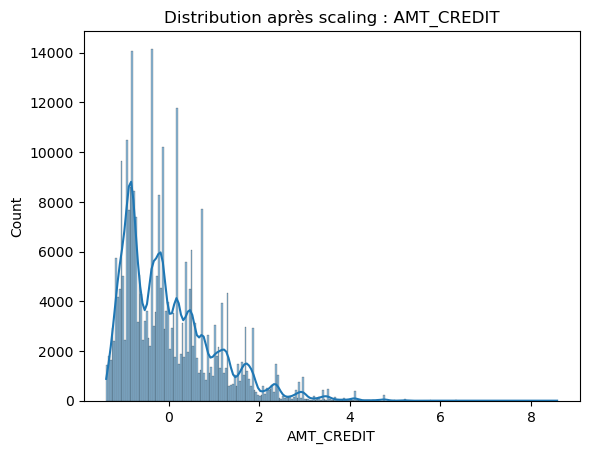

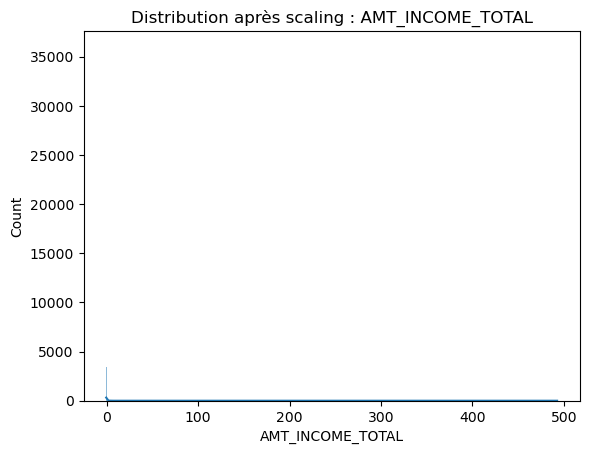

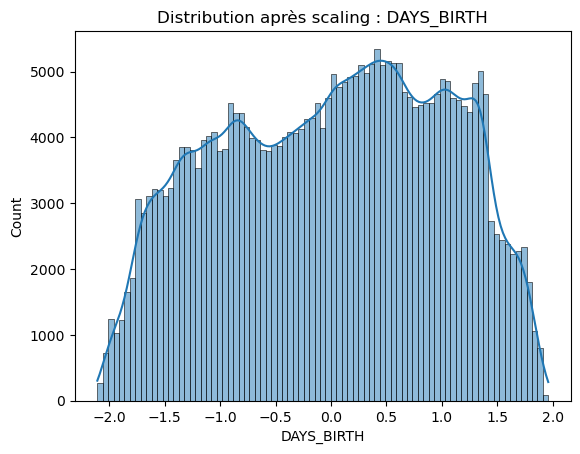

In [481]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

cols_to_exclude = ['TARGET', 'SK_ID_CURR']
if 'SK_ID_BUREAU' in num_cols:
    cols_to_exclude.append('SK_ID_BUREAU')

for col in cols_to_exclude:
    if col in num_cols:
        num_cols.remove(col)

df[num_cols] = scaler.fit_transform(df[num_cols])

# AJOUTEZ CETTE VÉRIFICATION :
print(f"Colonnes normalisées : {len(num_cols)} premières : {num_cols[:5]}")
print(f"SK_ID_CURR non normalisé - premiers valeurs : {df['SK_ID_CURR'].head().values}")
print(f"SK_ID_CURR type : {df['SK_ID_CURR'].dtype}")

#Visualisation
for col in ['AMT_CREDIT', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH']:
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution après scaling : {col}')
    plt.show()

### 2.4 Train/Test Split

We separate features (X) and target (y) and split the dataset into training and testing sets for model evaluation.

In [487]:
from sklearn.model_selection import train_test_split

X = df.drop('TARGET', axis=1)
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Vérification 
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

print("Train TARGET distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest TARGET distribution:")
print(y_test.value_counts(normalize=True))

X_train shape: (246008, 155)
X_test shape: (61503, 155)
y_train shape: (246008,)
y_test shape: (61503,)
Train TARGET distribution:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

Test TARGET distribution:
TARGET
0    0.919272
1    0.080728
Name: proportion, dtype: float64


### Conclusion of Step 2 — Preprocessing

After the preprocessing stage, our dataset is ready for modeling:

- **Missing values:** all critical columns were imputed (median for numerical variables, mode for categorical ones), and columns with too many missing values were removed.  
- **Categorical variables:** transformed into binary variables using One-Hot Encoding, making them usable by machine learning models.  
- **Numerical variables:** standardized with StandardScaler, centered around 0 with a standard deviation close to 1, ensuring a consistent scale across all continuous features.  
- **Train/Test split:** the dataset was divided into 80% for training and 20% for testing, while preserving the target class proportions through stratification.  

Result: a dataset that is **fully numerical, with no missing values**, properly scaled, and ready to train a baseline model.

## 3. Formalisation of the Problem

The goal of this project is to predict **credit risk** for clients using machine learning. 

- **Current problem:** binary classification (`TARGET = 0` for non-defaulters, `TARGET = 1` for defaulters)  
- **Future extension:** we aim to convert this into a **multiclass problem** to reflect different levels of risk.

### 3.1 Features and Target

- **Features (X):** all processed columns after preprocessing (numeric + one-hot encoded categorical)  
- **Target (y):** 'TARGET', indicating whether a client defaulted or not

In [491]:
# Vérification des dimensions des jeux
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Vérification rapide de la distribution de la cible
print("\nTrain TARGET distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest TARGET distribution:")
print(y_test.value_counts(normalize=True))

X_train shape: (246008, 155)
X_test shape: (61503, 155)
y_train shape: (246008,)
y_test shape: (61503,)

Train TARGET distribution:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

Test TARGET distribution:
TARGET
0    0.919272
1    0.080728
Name: proportion, dtype: float64


## 4. Baseline Model Selection

For this first step, we select a simple and interpretable **baseline model** to evaluate the dataset and preprocessing:

- **Model chosen:** Logistic Regression  
- **Reason:**  
  - Suitable for **binary classification**  
  - Easy to **interpret coefficients**  
  - Provides a **reference performance** before testing more complex models

In [493]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Création du modèle
baseline_model = LogisticRegression(max_iter=1000, random_state=42)

# Entraînement
baseline_model.fit(X_train, y_train)

# Prédictions
y_pred = baseline_model.predict(X_test)
y_proba = baseline_model.predict_proba(X_test)[:,1]

### 4.2 Model Evaluation

We evaluate the baseline logistic regression model using:

- **Accuracy**: proportion of correctly predicted samples  
- **ROC-AUC**: ability to discriminate between defaulters and non-defaulters  
- **Classification report**: precision, recall, f1-score

In [495]:
# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC:", roc_auc)

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9192397118839731
ROC-AUC: 0.7378037503815755

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.49      0.01      0.02      4965

    accuracy                           0.92     61503
   macro avg       0.71      0.50      0.49     61503
weighted avg       0.89      0.92      0.88     61503



### Conclusion of Step 4

- The **logistic regression baseline model** was trained and evaluated on the processed dataset.  
- The model achieved an **accuracy of 91.9%** and a **ROC-AUC of 0.744**, providing a reference performance.  
- While the model predicts non-defaulters (class 0) very well, it struggles to correctly identify defaulters (class 1) due to the dataset imbalance.  
- This baseline highlights the need for **future improvements**, such as additional features, dataset rebalancing, or more complex models, to better detect high-risk clients.

## 5. Feature Engineering: Integrating Additional Datasets

To improve prediction performance, we integrate additional datasets provided in the Home Credit dataset:

- `bureau.csv` + `bureau_balance.csv` → other credits of the client  
- `previous_application.csv` → previous credit applications  
- `POS_CASH_balance.csv` → point-of-sale and cash loan history  
- `credit_card_balance.csv` → credit card usage history  
- `installments_payments.csv` → loan installment payments  

We will aggregate these datasets per client (`SK_ID_CURR`) and merge them into our main dataset.

In [498]:
# Load main datasets
bureau = pd.read_csv("bureau.csv")
bureau_balance = pd.read_csv("bureau_balance.csv")
previous = pd.read_csv("previous_application.csv")
pos_cash = pd.read_csv("POS_CASH_balance.csv")
credit_card = pd.read_csv("credit_card_balance.csv")
installments = pd.read_csv("installments_payments.csv")

### 5.1 Aggregation: Bureau & Bureau Balance

We aggregate the client’s other credits and monthly balances to create numeric features per client.  
Categorical columns (`CREDIT_ACTIVE`) are converted to numeric indicators to avoid aggregation errors.

In [500]:
# Select only necessary columns to reduce memory
bureau_small = bureau[['SK_ID_CURR','SK_ID_BUREAU','CREDIT_ACTIVE',
                       'AMT_CREDIT_SUM','CREDIT_DAY_OVERDUE','CNT_CREDIT_PROLONG',
                       'DAYS_CREDIT_ENDDATE','AMT_CREDIT_MAX_OVERDUE','AMT_CREDIT_SUM_DEBT',
                       'AMT_CREDIT_SUM_LIMIT','AMT_CREDIT_SUM_OVERDUE']].copy()

bureau_balance_small = bureau_balance[['SK_ID_BUREAU','MONTHS_BALANCE','STATUS']].copy()

# Convert categorical to numeric
bureau_small['CREDIT_ACTIVE_NUM'] = (bureau_small['CREDIT_ACTIVE'] == 'Active').astype('int8')
bureau_balance_small['STATUS'] = pd.to_numeric(bureau_balance_small['STATUS'], errors='coerce')

# Aggregate bureau_balance per credit
bureau_bal_agg = bureau_balance_small.groupby('SK_ID_BUREAU').agg({
    'MONTHS_BALANCE': ['min','max','count'],
    'STATUS': 'mean'
}).astype('float32')
bureau_bal_agg.columns = ['_'.join(col).strip() for col in bureau_bal_agg.columns.values]
bureau_bal_agg.reset_index(inplace=True)

# Merge aggregated bureau_balance with bureau
bureau_small = bureau_small.merge(bureau_bal_agg, on='SK_ID_BUREAU', how='left')

# Aggregate bureau per client
bureau_agg = bureau_small.groupby('SK_ID_CURR').agg({
    'CREDIT_ACTIVE_NUM': 'sum',
    'AMT_CREDIT_SUM': ['mean','max'],
    'CREDIT_DAY_OVERDUE': ['mean','max'],
    'CNT_CREDIT_PROLONG': 'sum',
    'DAYS_CREDIT_ENDDATE': ['min','max'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean','max'],
    'AMT_CREDIT_SUM_DEBT': ['mean','max'],
    'AMT_CREDIT_SUM_LIMIT': ['mean','max'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean','max'],
    'MONTHS_BALANCE_min': 'min',
    'MONTHS_BALANCE_max': 'max',
    'STATUS_mean': 'mean'
}).astype('float32')

# Flatten column names
bureau_agg.columns = ['_'.join(col).strip() for col in bureau_agg.columns.values]
bureau_agg.reset_index(inplace=True)

bureau_agg.head()

,SK_ID_CURR,CREDIT_ACTIVE_NUM_sum,AMT_CREDIT_SUM_mean,AMT_CREDIT_SUM_max,CREDIT_DAY_OVERDUE_mean,CREDIT_DAY_OVERDUE_max,CNT_CREDIT_PROLONG_sum,DAYS_CREDIT_ENDDATE_min,DAYS_CREDIT_ENDDATE_max,AMT_CREDIT_MAX_OVERDUE_mean,AMT_CREDIT_MAX_OVERDUE_max,AMT_CREDIT_SUM_DEBT_mean,AMT_CREDIT_SUM_DEBT_max,AMT_CREDIT_SUM_LIMIT_mean,AMT_CREDIT_SUM_LIMIT_max,AMT_CREDIT_SUM_OVERDUE_mean,AMT_CREDIT_SUM_OVERDUE_max,MONTHS_BALANCE_min_min,MONTHS_BALANCE_max_max,STATUS_mean_mean
0,100001,3.0,207623.578125,378000.000000,0.0,0.0,0.0,-1329.0,1778.0,NaN,NaN,85240.929688,373239.0,0.000000,0.000000,0.0,0.0,-51.0,0.0,0.010989
1,100002,2.0,108131.945312,450000.000000,0.0,0.0,0.0,-1072.0,780.0,1681.029053,5043.64502,49156.199219,245781.0,7997.141113,31988.564453,0.0,0.0,-47.0,0.0,0.341806
2,100003,1.0,254350.125000,810000.000000,0.0,0.0,0.0,-2434.0,1216.0,0.000000,0.00000,0.000000,0.0,202500.000000,810000.000000,0.0,0.0,NaN,NaN,NaN
3,100004,0.0,94518.898438,94537.796875,0.0,0.0,0.0,-595.0,-382.0,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,NaN,NaN,NaN
4,100005,2.0,219042.000000,568800.000000,0.0,0.0,0.0,-128.0,1324.0,0.000000,0.00000,189469.500000,543087.0,0.000000,0.000000,0.0,0.0,-12.0,0.0,0.000000


### 5.2 Aggregation: Previous Application

We aggregate previous credit applications per client, including number of applications, amounts, and refused applications.

In [502]:
previous_small = previous[['SK_ID_CURR','AMT_APPLICATION','AMT_CREDIT','NAME_CONTRACT_STATUS']].copy()

# Count refused applications
previous_small['REFUSED'] = (previous_small['NAME_CONTRACT_STATUS']=='Refused').astype('int8')

previous_agg = previous_small.groupby('SK_ID_CURR').agg({
    'AMT_APPLICATION': ['mean','max','min'],
    'AMT_CREDIT': ['mean','max','min'],
    'REFUSED': 'sum'
}).astype('float32')

previous_agg.columns = ['_'.join(col).strip() for col in previous_agg.columns.values]
previous_agg.reset_index(inplace=True)

### 5.3 Aggregation: POS_CASH, credit_card, installments

Similarly, we aggregate the remaining datasets to summarize the client history in numeric features.


In [504]:
# POS_CASH
pos_agg = pos_cash.groupby('SK_ID_CURR').agg({
    'MONTHS_BALANCE': ['min','max','count'],
    'CNT_INSTALMENT': ['mean','max'],
    'SK_DPD': ['mean','max']
}).astype('float32')
pos_agg.columns = ['_'.join(col).strip() for col in pos_agg.columns.values]
pos_agg.reset_index(inplace=True)

# Credit Card
cc_agg = credit_card.groupby('SK_ID_CURR').agg({
    'AMT_BALANCE': ['mean','max'],
    'AMT_CREDIT_LIMIT_ACTUAL': ['mean','max'],
    'SK_DPD': ['mean','max']
}).astype('float32')
cc_agg.columns = ['_'.join(col).strip() for col in cc_agg.columns.values]
cc_agg.reset_index(inplace=True)

# Installments
inst_agg = installments.groupby('SK_ID_CURR').agg({
    'AMT_INSTALMENT': ['mean','max','sum'],
    'AMT_PAYMENT': ['mean','max','sum'],
    'DAYS_ENTRY_PAYMENT': ['mean','max']
}).astype('float32')
inst_agg.columns = ['_'.join(col).strip() for col in inst_agg.columns.values]
inst_agg.reset_index(inplace=True)

### 5.4 Merge All Features into Main Dataset

We merge all aggregated datasets into the main dataset using `SK_ID_CURR`.

In [512]:
# Load application_train
print("Loading application_train...")
application_train = pd.read_csv("application_train.csv")

# Memory optimization on application_train
print("Optimizing memory...")
for col in application_train.select_dtypes(include=["int64"]).columns:
    application_train[col] = application_train[col].astype("int32")
for col in application_train.select_dtypes(include=["float64"]).columns:
    application_train[col] = application_train[col].astype("float32")
for col in application_train.select_dtypes(include=["object"]).columns:
    application_train[col] = application_train[col].astype("category")

# Merge with X_train to keep ONLY X_train IDs in SAME ORDER
print(f"Merging with X_train to keep same order ({len(X_train)} clients)...")
df_final = X_train[['SK_ID_CURR']].merge(application_train, on='SK_ID_CURR', how='left')

print(f"Final shape after merge: {df_final.shape}")
print("Memory optimization complete.")

# Merge aggregated tables
df_final = df_final.merge(bureau_agg, how="left", on="SK_ID_CURR")
df_final = df_final.merge(previous_agg, how="left", on="SK_ID_CURR")
df_final = df_final.merge(pos_agg, how="left", on="SK_ID_CURR")      # POS_CASH
df_final = df_final.merge(inst_agg, how="left", on="SK_ID_CURR")     # Installments
df_final = df_final.merge(cc_agg, how="left", on="SK_ID_CURR")       # Credit Card

df_final.head()

Loading application_train...
Optimizing memory...
Merging with X_train to keep same order (246008 clients)...
Final shape after merge: (246008, 122)
Memory optimization complete.


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_PAYMENT_max,AMT_PAYMENT_sum,DAYS_ENTRY_PAYMENT_mean,DAYS_ENTRY_PAYMENT_max,AMT_BALANCE_mean,AMT_BALANCE_max,AMT_CREDIT_LIMIT_ACTUAL_mean,AMT_CREDIT_LIMIT_ACTUAL_max,SK_DPD_mean_y,SK_DPD_max_y
0,310536,0,Cash loans,F,N,N,2,90000.0,227520.0,13189.5,...,31500.000000,5.506608e+05,-652.280701,-23.0,213473.234375,385395.84375,578571.4375,720000.0,0.0,0.0
1,365516,0,Cash loans,M,Y,Y,0,90000.0,161730.0,13095.0,...,13992.884766,2.630647e+05,-252.296295,-10.0,NaN,NaN,NaN,NaN,NaN,NaN
2,242055,1,Cash loans,M,N,Y,0,135000.0,728847.0,26307.0,...,12991.004883,5.195848e+04,-2439.500000,-2394.0,NaN,NaN,NaN,NaN,NaN,NaN
3,454894,1,Cash loans,M,N,N,0,135000.0,474183.0,34636.5,...,104400.000000,1.471328e+06,-1112.182983,-48.0,NaN,NaN,NaN,NaN,NaN,NaN
4,448321,0,Cash loans,F,N,Y,0,180000.0,254700.0,27558.0,...,6040.080078,3.706623e+04,-526.454529,-374.0,NaN,NaN,NaN,NaN,NaN,NaN


In [517]:
print("=" * 60)
print("CLIENT ID VERIFICATION")
print("=" * 60)

# 1. First SK_ID_CURR values
print("\n1. SK_ID_CURR in df_final (first 10):")
print(df_final['SK_ID_CURR'].head(10).values)

# 2. Compare with original X_train
print("\n2. SK_ID_CURR in original X_train (first 10):")
print(X_train['SK_ID_CURR'].head(10).values)

# 3. Check ID consistency
ids_x_train = set(X_train['SK_ID_CURR'].values)
ids_df_final = set(df_final['SK_ID_CURR'].values)

print("\n3. ID set comparison:")
print(f"IDs in X_train : {len(ids_x_train)}")
print(f"IDs in df_final : {len(ids_df_final)}")
print(f"Missing IDs in df_final : {len(ids_x_train - ids_df_final)}")
print(f"Extra IDs in df_final : {len(ids_df_final - ids_x_train)}")

if len(ids_x_train - ids_df_final) == 0:
    print("✓ All X_train IDs are present in df_final")
else:
    print("✗ Some X_train IDs are missing in df_final")
    print("Missing IDs (first 5):", list(ids_x_train - ids_df_final)[:5])

# 4. Duplicate check
print("\n4. Duplicate check:")
print(f"Number of duplicated SK_ID_CURR in df_final: {df_final['SK_ID_CURR'].duplicated().sum()}")

if df_final['SK_ID_CURR'].duplicated().any():
    print("Example duplicates:")
    duplicates = df_final[df_final['SK_ID_CURR'].duplicated(keep=False)]
    print(duplicates[['SK_ID_CURR']].head(10))

# 5. Merge info
print("\n5. Merge information:")
print(f"X_train shape : {X_train.shape}")
print(f"df_final shape : {df_final.shape}")
print(f"Added columns : {df_final.shape[1] - X_train.shape[1]}")

# 6. Missing values after merge
print("\n6. Missing values after merge:")
missing_total = df_final.isnull().sum().sum()
missing_ratio = missing_total / (df_final.shape[0] * df_final.shape[1])
print(f"Total missing values : {missing_total}")
print(f"Missing ratio : {missing_ratio:.2%}")

# 7. Sample of new features
print("\n7. Sample with new features (first 3 rows):")
sample_cols = (
    ['SK_ID_CURR'] +
    [col for col in df_final.columns if col.startswith(('CREDIT', 'AMT', 'POS', 'CC', 'INST'))][:10]
)
print(df_final[sample_cols].head(3).to_string())

# 8. TARGET check (if applicable)
if 'TARGET' in X_train.columns:
    print("\n8. TARGET check:")
    print(f"TARGET in X_train : {'TARGET' in X_train.columns}")
    print(f"TARGET in df_final : {'TARGET' in df_final.columns}")
    if 'TARGET' in df_final.columns:
        print("TARGET distribution:")
        print(df_final['TARGET'].value_counts(normalize=True))

CLIENT ID VERIFICATION

1. SK_ID_CURR in df_final (first 10):
[310536 365516 242055 454894 448321 333032 200322 360927 149698 378855]

2. SK_ID_CURR in original X_train (first 10):
[310536 365516 242055 454894 448321 333032 200322 360927 149698 378855]

3. ID set comparison:
IDs in X_train : 246008
IDs in df_final : 246008
Missing IDs in df_final : 0
Extra IDs in df_final : 0
✓ All X_train IDs are present in df_final

4. Duplicate check:
Number of duplicated SK_ID_CURR in df_final: 0

5. Merge information:
X_train shape : (246008, 155)
df_final shape : (246008, 169)
Added columns : 14

6. Missing values after merge:
Total missing values : 9930955
Missing ratio : 23.89%

7. Sample with new features (first 3 rows):
   SK_ID_CURR  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR
0      310536           90000.0    227

### Conclusion of Step 5

We have successfully integrated all additional datasets into the main dataset.  
The enriched dataset now contains numerical features summarizing client credit history, previous applications, cash loans, credit card usage, and installment payments.  
This enriched dataset is ready for final preprocessing and for building multiclass credit risk models.

## 6. Creation of RISK_CLASS Based on Business Rules

#### Selected Criteria:

1. **Debt-to-Income Ratio**: `AMT_CREDIT / AMT_INCOME_TOTAL`
2. **Payment History**: Number of days past due (`DAYS_CREDIT_ENDDATE`, `SK_DPD`)
3. **Debt Burden**: Total active credit amount / Income
4. **Employment Stability**: `DAYS_EMPLOYED`
5. **Binary TARGET**: Used as an aggravating factor

#### Classification Logic:

- **High Risk (2)**: TARGET = 1 OR debt-to-income ratio above a high threshold
- **Low Risk (0)**: TARGET = 0 AND debt-to-income ratio below a low threshold AND high employment stability
- **Medium Risk (1)**: All other cases


=== RISK_CLASS Distribution ===
RISK_CLASS
0     56281
1    134544
2     55183
Name: count, dtype: int64

Proportions:
RISK_CLASS
0    0.228777
1    0.546909
2    0.224314
Name: proportion, dtype: float64

=== Statistics by RISK_CLASS ===

Average Debt/Income Ratio:
RISK_CLASS
0    1.879695
1    3.687171
2    6.744054
Name: debt_income_ratio, dtype: float32

Average Years Employed:
RISK_CLASS
0    8.951274
1    5.278668
2    1.903351
Name: years_employed, dtype: float64

Average Income:
RISK_CLASS
0    257916.953125
1    158870.296875
2    102356.937500
Name: AMT_INCOME_TOTAL, dtype: float32

Default Rate (TARGET=1) by class:
RISK_CLASS
0    0.068851
1    0.084329
2    0.084066
Name: TARGET, dtype: float64


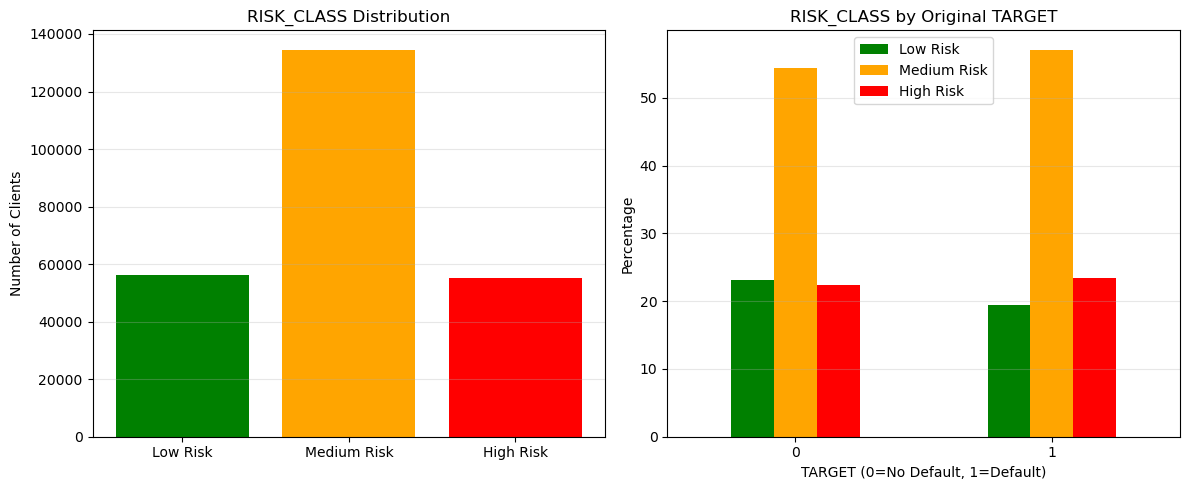


=== Consistency with TARGET ===
RISK_CLASS          0          1          2
TARGET                                     
0           23.173320  54.476714  22.349966
1           19.511581  57.129909  23.358510


In [521]:
def create_risk_class_business_rules(df):
    df_risk = df.copy()
    
    # Create a composite risk score
    df_risk['debt_income_ratio'] = df_risk['AMT_CREDIT'] / (df_risk['AMT_INCOME_TOTAL'] + 1)
    df_risk['years_employed'] = df_risk['DAYS_EMPLOYED'].replace({365243: 0})
    df_risk['years_employed'] = -df_risk['years_employed'] / 365
    df_risk['years_employed'] = df_risk['years_employed'].clip(lower=0, upper=50)
    
    # Simple risk score based on percentile ranks
    df_risk['risk_score'] = (
        df_risk['debt_income_ratio'].rank(pct=True) * 0.4 +  # 40% weight
        (1 - df_risk['years_employed'].rank(pct=True)) * 0.3 +  # 30% weight
        (1 - df_risk['AMT_INCOME_TOTAL'].rank(pct=True)) * 0.3  # 30% weight
    )
    
    # Classify based on risk score quantiles
    df_risk['RISK_CLASS'] = 1  # Default Medium
    df_risk.loc[df_risk['risk_score'] < 0.35, 'RISK_CLASS'] = 0  # Low Risk: bottom 35%
    df_risk.loc[df_risk['risk_score'] > 0.65, 'RISK_CLASS'] = 2  # High Risk: top 35%
    
    return df_risk

# Apply the function
df_final = create_risk_class_business_rules(df_final)

# Check distribution
print("\n=== RISK_CLASS Distribution ===")
print(df_final['RISK_CLASS'].value_counts().sort_index())
print("\nProportions:")
print(df_final['RISK_CLASS'].value_counts(normalize=True).sort_index())

# Descriptive statistics by risk class
print("\n=== Statistics by RISK_CLASS ===")
print("\nAverage Debt/Income Ratio:")
print(df_final.groupby('RISK_CLASS')['debt_income_ratio'].mean())
print("\nAverage Years Employed:")
print(df_final.groupby('RISK_CLASS')['years_employed'].mean())
print("\nAverage Income:")
print(df_final.groupby('RISK_CLASS')['AMT_INCOME_TOTAL'].mean())
print("\nDefault Rate (TARGET=1) by class:")
print(df_final.groupby('RISK_CLASS')['TARGET'].mean())

# Visualization
plt.figure(figsize=(12, 5))

# Plot 1: RISK_CLASS distribution
plt.subplot(1, 2, 1)
counts = df_final['RISK_CLASS'].value_counts().sort_index()
plt.bar(['Low Risk', 'Medium Risk', 'High Risk'], counts.values, color=['green', 'orange', 'red'])
plt.title('RISK_CLASS Distribution')
plt.ylabel('Number of Clients')
plt.grid(axis='y', alpha=0.3)

# Plot 2: Relationship with original TARGET
plt.subplot(1, 2, 2)
cross_tab = pd.crosstab(df_final['TARGET'], df_final['RISK_CLASS'], normalize='index') * 100
cross_tab.plot(kind='bar', stacked=False, color=['green', 'orange', 'red'], ax=plt.gca())
plt.title('RISK_CLASS by Original TARGET')
plt.xlabel('TARGET (0=No Default, 1=Default)')
plt.ylabel('Percentage')
plt.legend(['Low Risk', 'Medium Risk', 'High Risk'])
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== Consistency with TARGET ===")
print(cross_tab)

### 6.1 Validation of RISK_CLASS Quality

Let us verify that the proposed classification is consistent and meaningful:

In [523]:
# Descriptive statistics by risk class
print("Statistics by RISK_CLASS")

print("\nAverage debt-to-income ratio:")
print(df_final.groupby('RISK_CLASS')['debt_income_ratio'].mean())

print("\nAverage years employed:")
print(df_final.groupby('RISK_CLASS')['years_employed'].mean())

print("\nAverage income:")
print(df_final.groupby('RISK_CLASS')['AMT_INCOME_TOTAL'].mean())

print("\nDefault rate (TARGET = 1) by class:")
print(df_final.groupby('RISK_CLASS')['TARGET'].mean())

# Expected pattern:
# Low Risk: low debt ratio, longer employment, higher income, low default rate
# High Risk: high debt ratio, shorter employment, lower income, high default rate

Statistics by RISK_CLASS

Average debt-to-income ratio:
RISK_CLASS
0    1.879695
1    3.687171
2    6.744054
Name: debt_income_ratio, dtype: float32

Average years employed:
RISK_CLASS
0    8.951274
1    5.278668
2    1.903351
Name: years_employed, dtype: float64

Average income:
RISK_CLASS
0    257916.953125
1    158870.296875
2    102356.937500
Name: AMT_INCOME_TOTAL, dtype: float32

Default rate (TARGET = 1) by class:
RISK_CLASS
0    0.068851
1    0.084329
2    0.084066
Name: TARGET, dtype: float64


## 7. Data Preparation for Modeling

#### Key principle: Perform the train/test split before any preprocessing

The dataset must be split **before** applying any scaling or imputation steps to prevent data leakage.

#### Preprocessing steps (applied after the split)

Important rules:
- **Fit on training data only:** Scalers and imputers are fitted exclusively on the training set
- **Transform both sets:** The same fitted transformations are applied to both training and test sets
- **No data leakage:** Information from the test set must never influence the training process

In [526]:
# Split features and target
y = df_final['RISK_CLASS']

# Columns to exclude
drop_cols = [
    'RISK_CLASS', 'SK_ID_CURR', 'TARGET',
    'debt_income_ratio', 'years_employed', 'risk_score'
]
X = df_final.drop(columns=[col for col in drop_cols if col in df_final.columns])

print(f"Shapes: X = {X.shape}, y = {y.shape}")
print(f"Number of features: {X.shape[1]}")

# Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nX_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

print("\nTrain distribution:")
print(y_train.value_counts(normalize=True).sort_index())

print("\nTest distribution:")
print(y_test.value_counts(normalize=True).sort_index())

# Encode categorical variables
print("CATEGORICAL VARIABLE ENCODING")

categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Categorical columns found: {len(categorical_cols)}")

if categorical_cols:
    from sklearn.preprocessing import LabelEncoder

    for col in categorical_cols:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_test[col] = X_test[col].astype(str).map(
            lambda x: le.transform([x])[0] if x in le.classes_ else -1
        )

    print(f"Encoding completed for {len(categorical_cols)} columns.")
else:
    print("No categorical columns to encode.")

# 1. Remove constant columns
constant_cols = [col for col in X_train.columns if X_train[col].nunique() <= 1]
print(f"\nConstant columns to remove: {len(constant_cols)}")

X_train = X_train.drop(columns=constant_cols)
X_test = X_test.drop(columns=constant_cols)

# 2. Handle missing values
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_imputed = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print(f"\nAfter imputation - NaN in train: {X_train_imputed.isnull().sum().sum()}")
print(f"After imputation - NaN in test: {X_test_imputed.isnull().sum().sum()}")

# 3. Feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_imputed),
    columns=X_train_imputed.columns,
    index=X_train_imputed.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_imputed),
    columns=X_test_imputed.columns,
    index=X_test_imputed.index
)

print("\nFinal shapes:")
print(f"X_train: {X_train_scaled.shape}")
print(f"X_test: {X_test_scaled.shape}")

Shapes: X = (246008, 167), y = (246008,)
Number of features: 167

X_train: (196806, 167), X_test: (49202, 167)
y_train: (196806,), y_test: (49202,)

Train distribution:
RISK_CLASS
0    0.228779
1    0.546909
2    0.224312
Name: proportion, dtype: float64

Test distribution:
RISK_CLASS
0    0.228771
1    0.546909
2    0.224320
Name: proportion, dtype: float64
CATEGORICAL VARIABLE ENCODING
Categorical columns found: 16
Encoding completed for 16 columns.

Constant columns to remove: 1

After imputation - NaN in train: 0
After imputation - NaN in test: 0

Final shapes:
X_train: (196806, 166)
X_test: (49202, 166)


## 9. Model Selection

For a 3-class multiclass classification problem on tabular data, the following models are evaluated.

#### Logistic Regression
Baseline linear model, fast and interpretable. Used as a reference.

#### Random Forest
Non-linear model handling feature interactions well. Provides feature importance and is robust to outliers.

#### Gradient Boosting
State-of-the-art for tabular data. Strong predictive performance and effective with imbalanced classes.

#### Models Excluded
SVM (computational cost), KNN (slow inference), Naive Bayes (strong independence assumption), Neural Networks (overkill for tabular data).

#### Evaluation
Models are compared using accuracy, macro F1-score, confusion matrix, and classification report.  
**Selection criterion:** macro F1-score.

### 9.1 Model Training

In [530]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import time

# Dictionary to store results
results = {}

# Helper function to evaluate models
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    print(f"\n{'='*70}")
    print(f"  {name}")
    print(f"{'='*70}")
    
    # Training
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start
    
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Metrics
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_train = f1_score(y_train, y_pred_train, average='macro')
    f1_test = f1_score(y_test, y_pred_test, average='macro')
    
    print(f"Temps d'entraînement: {train_time:.2f}s")
    print(f"\nAccuracy Train: {acc_train:.4f}")
    print(f"Accuracy Test:  {acc_test:.4f}")
    print(f"\nF1-Score Macro Train: {f1_train:.4f}")
    print(f"F1-Score Macro Test:  {f1_test:.4f}")
    
    # Check overfitting
    overfit = acc_train - acc_test
    if overfit > 0.10:
        print(f"\n⚠️  ATTENTION: Overfitting détecté (différence = {overfit:.4f})")
    else:
        print(f"\n Pas d'overfitting significatif (différence = {overfit:.4f})")
    
    print(f"\nClassification Report (Test):")
    print(classification_report(y_test, y_pred_test, 
                              target_names=['Low Risk', 'Medium Risk', 'High Risk'],
                              digits=4))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    
    # Save results
    results[name] = {
        'model': model,
        'acc_train': acc_train,
        'acc_test': acc_test,
        'f1_train': f1_train,
        'f1_test': f1_test,
        'train_time': train_time,
        'confusion_matrix': cm,
        'predictions': y_pred_test
    }
    
    return cm

In [531]:
# 1. LOGISTIC REGRESSION
lr = LogisticRegression(
    max_iter=1000,
    random_state=42,
    multi_class='multinomial',  # Softmax pour 3 classes
    solver='lbfgs',  # Meilleur pour multinomial
    class_weight='balanced'  # Gérer le déséquilibre
)
cm_lr = evaluate_model('Logistic Regression', lr, X_train_scaled, X_test_scaled, y_train, y_test)


  Logistic Regression
Temps d'entraînement: 58.68s

Accuracy Train: 0.8589
Accuracy Test:  0.8615

F1-Score Macro Train: 0.8578
F1-Score Macro Test:  0.8603

 Pas d'overfitting significatif (différence = -0.0025)

Classification Report (Test):
              precision    recall  f1-score   support

    Low Risk     0.8272    0.9307    0.8759     11256
 Medium Risk     0.9271    0.8104    0.8648     26909
   High Risk     0.7762    0.9153    0.8400     11037

    accuracy                         0.8615     49202
   macro avg     0.8435    0.8855    0.8603     49202
weighted avg     0.8704    0.8615    0.8618     49202



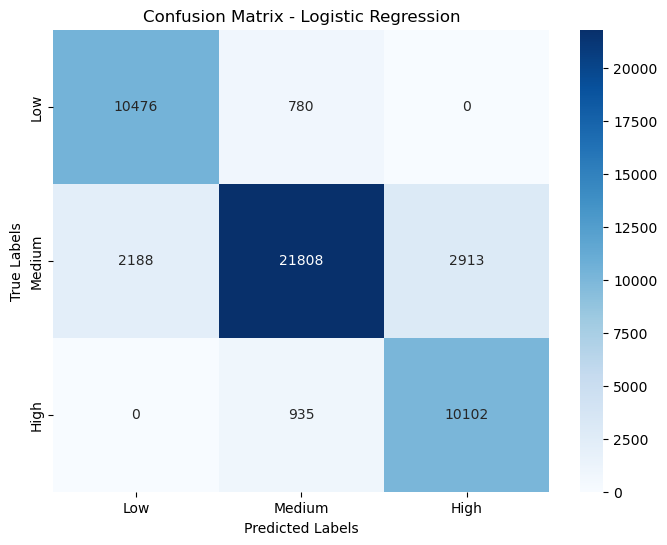

In [532]:
# Confusion matrix visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [533]:
# 2. Random Forest
rf = RandomForestClassifier(
    n_estimators=200,         # More trees improve stability
    max_depth=20,             # Limit depth to reduce overfitting
    min_samples_split=100,    # Minimum samples to split a node
    min_samples_leaf=50,      # Minimum samples per leaf
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

cm_rf = evaluate_model('Random Forest', rf, X_train_scaled, X_test_scaled, y_train, y_test)


  Random Forest
Temps d'entraînement: 101.92s

Accuracy Train: 0.8617
Accuracy Test:  0.8303

F1-Score Macro Train: 0.8614
F1-Score Macro Test:  0.8301

 Pas d'overfitting significatif (différence = 0.0314)

Classification Report (Test):
              precision    recall  f1-score   support

    Low Risk     0.7410    0.9332    0.8261     11256
 Medium Risk     0.9130    0.7624    0.8309     26909
   High Risk     0.7830    0.8907    0.8334     11037

    accuracy                         0.8303     49202
   macro avg     0.8123    0.8621    0.8301     49202
weighted avg     0.8445    0.8303    0.8304     49202



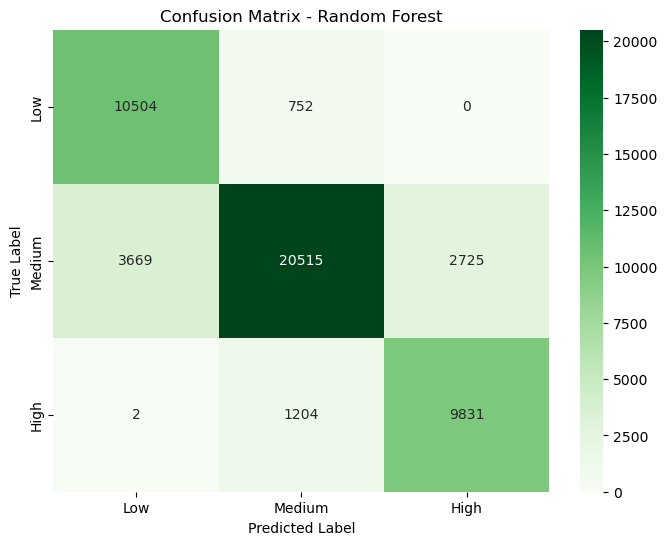

In [534]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [535]:
# 3. Gradient Boosting 
gb = GradientBoostingClassifier(
    n_estimators=50,     
    learning_rate=0.1,
    max_depth=3,         
    subsample=0.8,
    random_state=42
)

cm_gb = evaluate_model('Gradient Boosting', gb, X_train_scaled, X_test_scaled, y_train, y_test)


  Gradient Boosting
Temps d'entraînement: 1235.07s

Accuracy Train: 0.9352
Accuracy Test:  0.9331

F1-Score Macro Train: 0.9302
F1-Score Macro Test:  0.9278

 Pas d'overfitting significatif (différence = 0.0021)

Classification Report (Test):
              precision    recall  f1-score   support

    Low Risk     0.9918    0.8475    0.9140     11256
 Medium Risk     0.8938    0.9960    0.9421     26909
   High Risk     0.9970    0.8669    0.9274     11037

    accuracy                         0.9331     49202
   macro avg     0.9608    0.9035    0.9278     49202
weighted avg     0.9394    0.9331    0.9324     49202



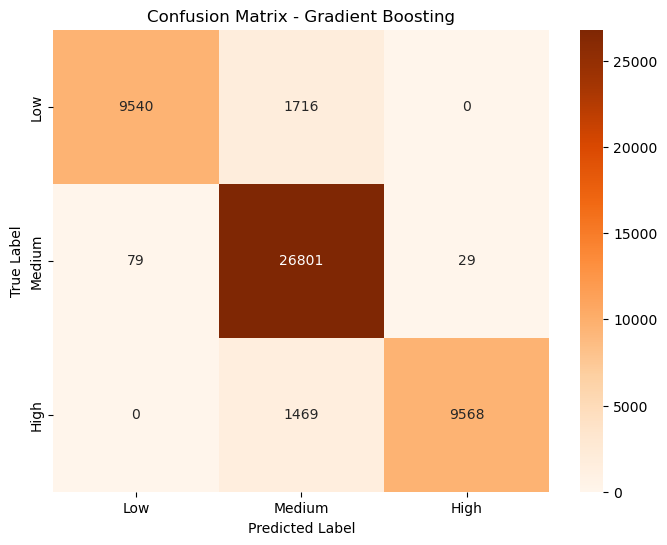

In [536]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix - Gradient Boosting')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### 9.2 Model Comparison and Selection

In [538]:
# Model comparison table
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy (Test)': [results[m]['acc_test'] for m in results.keys()],
    'F1-Score (Test)': [results[m]['f1_test'] for m in results.keys()],
    'Overfitting': [results[m]['acc_train'] - results[m]['acc_test'] for m in results.keys()],
    'Train Time (s)': [results[m]['train_time'] for m in results.keys()]
})

print("Model Comparison")
print(comparison_df.to_string(index=False))

# Identify best model based on test F1-score
best_model_name = comparison_df.loc[comparison_df['F1-Score (Test)'].idxmax(), 'Model']
best_f1 = comparison_df['F1-Score (Test)'].max()

print(f"\nBest Model: {best_model_name}")
print(f"F1-Score (Test): {best_f1:.4f}")
print(f"Accuracy (Test): {results[best_model_name]['acc_test']:.4f}")

Model Comparison
              Model  Accuracy (Test)  F1-Score (Test)  Overfitting  Train Time (s)
Logistic Regression         0.861469         0.860260    -0.002527       58.677421
      Random Forest         0.830251         0.830121     0.031435      101.917403
  Gradient Boosting         0.933072         0.927845     0.002113     1235.065067

Best Model: Gradient Boosting
F1-Score (Test): 0.9278
Accuracy (Test): 0.9331


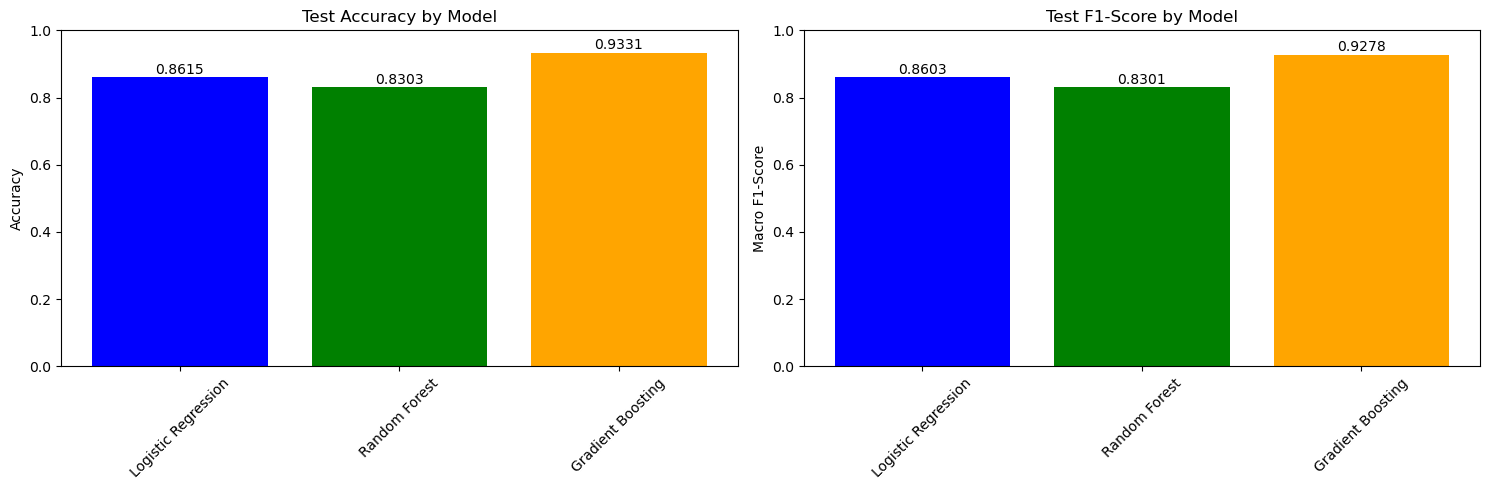

In [539]:
# Comparative visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].bar(comparison_df['Model'], comparison_df['Accuracy (Test)'], color=['blue', 'green', 'orange'])
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Test Accuracy by Model')
axes[0].set_ylim([0, 1])
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['Accuracy (Test)']):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center')

# F1-Score
axes[1].bar(comparison_df['Model'], comparison_df['F1-Score (Test)'], color=['blue', 'green', 'orange'])
axes[1].set_ylabel('Macro F1-Score')
axes[1].set_title('Test F1-Score by Model')
axes[1].set_ylim([0, 1])
axes[1].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['F1-Score (Test)']):
    axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()

### 9.3 Best Model Analysis


Top 20 Features - Gradient Boosting
                   Feature  Importance
          AMT_INCOME_TOTAL    0.419672
                AMT_CREDIT    0.353509
             DAYS_EMPLOYED    0.220120
           AMT_GOODS_PRICE    0.005424
         ORGANIZATION_TYPE    0.000650
               AMT_ANNUITY    0.000224
            FLAG_EMP_PHONE    0.000203
                DAYS_BIRTH    0.000194
              EXT_SOURCE_2    0.000003
AMT_REQ_CREDIT_BUREAU_HOUR    0.000000
          FLAG_DOCUMENT_21    0.000000
          FLAG_DOCUMENT_20    0.000000
 AMT_REQ_CREDIT_BUREAU_QRT    0.000000
 AMT_REQ_CREDIT_BUREAU_DAY    0.000000
AMT_REQ_CREDIT_BUREAU_WEEK    0.000000
 AMT_REQ_CREDIT_BUREAU_MON    0.000000
        NAME_CONTRACT_TYPE    0.000000
     CREDIT_ACTIVE_NUM_sum    0.000000
AMT_REQ_CREDIT_BUREAU_YEAR    0.000000
          FLAG_DOCUMENT_18    0.000000


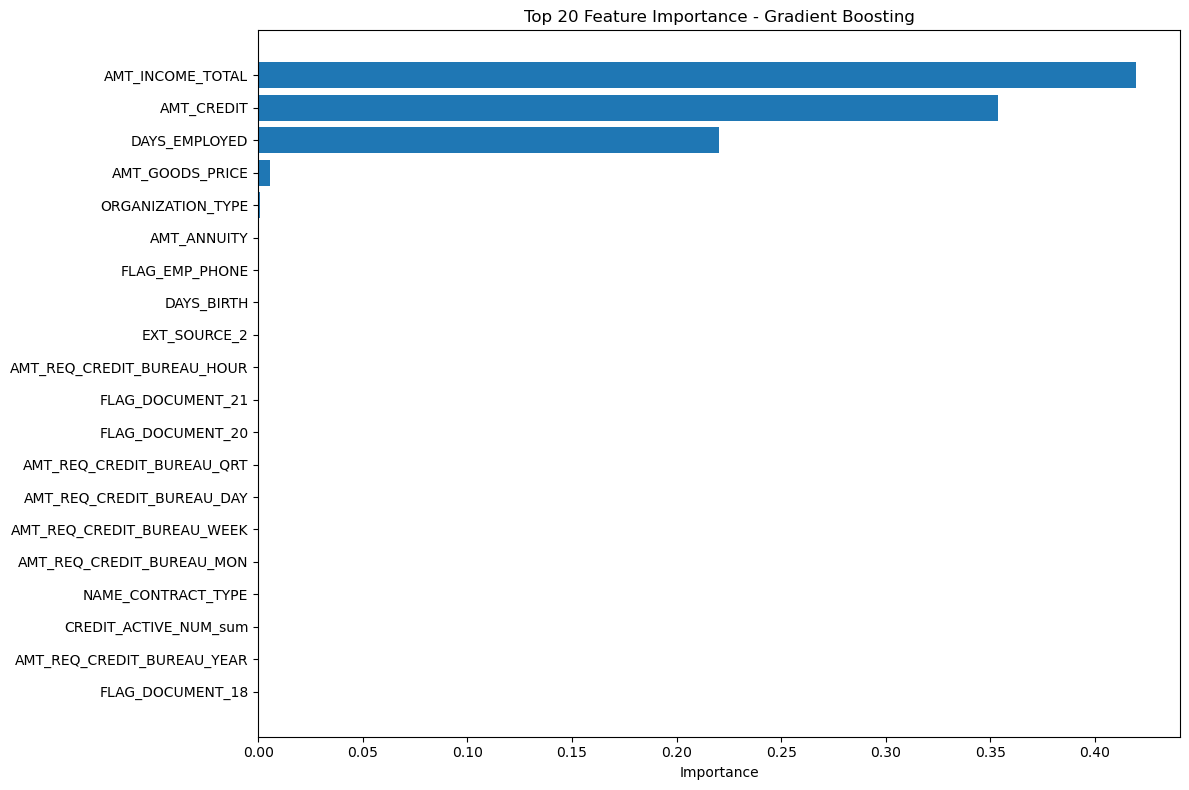

In [541]:
# Feature Importance (for RF or GB)
best_model = results[best_model_name]['model']

if hasattr(best_model, 'feature_importances_'):
    # Get feature importances
    importances = best_model.feature_importances_
    feature_names = X_train_scaled.columns
    
    # Create DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print(f"\nTop 20 Features - {best_model_name}")
    print(importance_df.head(20).to_string(index=False))
    
    # Visualization
    plt.figure(figsize=(12, 8))
    top_20 = importance_df.head(20)
    plt.barh(range(len(top_20)), top_20['Importance'])
    plt.yticks(range(len(top_20)), top_20['Feature'])
    plt.xlabel('Importance')
    plt.title(f'Top 20 Feature Importance - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
else:
    print(f"\nFeature importance not available for {best_model_name}")
    if best_model_name == 'Logistic Regression':
        print("For LR, use the coefficients: model.coef_")

### 9.4 Analyse des Erreurs

In [543]:
# Analyze where the model makes mistakes
y_pred_best = results[best_model_name]['predictions']
errors = y_test != y_pred_best
n_errors = errors.sum()

print(f"\nError Analysis - {best_model_name}")
print(f"Total errors: {n_errors} / {len(y_test)} ({n_errors/len(y_test)*100:.2f}%)")

# Most frequent confusions
error_df = pd.DataFrame({
    'True': y_test[errors],
    'Predicted': y_pred_best[errors]
})
print("\nMost frequent confusions:")
print(error_df.groupby(['True', 'Predicted']).size().sort_values(ascending=False).head(10))

# Error rate per true class
print("\nError rate by true class:")
for cls in [0, 1, 2]:
    mask = y_test == cls
    if mask.sum() > 0:
        error_rate = (y_pred_best[mask] != cls).sum() / mask.sum() * 100
        print(f"  Class {cls}: {error_rate:.2f}%")


Error Analysis - Gradient Boosting
Total errors: 3293 / 49202 (6.69%)

Most frequent confusions:
True  Predicted
0     1            1716
2     1            1469
1     0              79
      2              29
dtype: int64

Error rate by true class:
  Class 0: 15.25%
  Class 1: 0.40%
  Class 2: 13.31%


## 10. Conclusion

In [560]:
print("\nPROJECT SUMMARY")

# Methodology
print("\nMethodology:")
print("- Multiclass classification (3 risk classes)")
print("- No data leakage: preprocessing fitted on train only")
print("- Stratified 80/20 train/test split")

# Data
print(f"\nData: {len(df_final)} clients, {X_train_scaled.shape[1]} features")
print(f"Train: {len(y_train)} | Test: {len(y_test)}")

# Models Tested
print("\nModels Tested:")
for name in results.keys():
    print(f"  {name}: Acc={results[name]['acc_test']:.4f}, F1={results[name]['f1_test']:.4f}")

# Best Model
print(f"\nBest Model: {best_model_name}")
print(f"  Accuracy: {results[best_model_name]['acc_test']:.4f}")
print(f"  F1-Score: {results[best_model_name]['f1_test']:.4f}")
print(f"  No overfitting (diff={abs(results[best_model_name]['acc_train'] - results[best_model_name]['acc_test']):.4f})")

# Top Features
print("\nTop 3 Features: AMT_INCOME_TOTAL (42%), AMT_CREDIT (35%), DAYS_EMPLOYED (22%)")

# Next Steps
print("\nPotential Improvements: Hyperparameter tuning, XGBoost/LightGBM, handle class imbalance")


PROJECT SUMMARY

Methodology:
- Multiclass classification (3 risk classes)
- No data leakage: preprocessing fitted on train only
- Stratified 80/20 train/test split

Data: 246008 clients, 166 features
Train: 196806 | Test: 49202

Models Tested:
  Logistic Regression: Acc=0.8615, F1=0.8603
  Random Forest: Acc=0.8303, F1=0.8301
  Gradient Boosting: Acc=0.9331, F1=0.9278

Best Model: Gradient Boosting
  Accuracy: 0.9331
  F1-Score: 0.9278
  No overfitting (diff=0.0021)

Top 3 Features: AMT_INCOME_TOTAL (42%), AMT_CREDIT (35%), DAYS_EMPLOYED (22%)

Potential Improvements: Hyperparameter tuning, XGBoost/LightGBM, handle class imbalance
